In [1]:
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import json
import re

In [2]:
# Load results from JSON files
results_dir = "../results"

def libname_of_path(path):
    return re.search(".*lib(.*)\.so.\d", path).group(1)


with open(f"{results_dir}/baseline.json") as fp_baseline:
    res = dict()
    raw = json.load(fp_baseline)
    outer_iterations = raw['dlopen-dlclose']['outer-iterations']
    inner_iterations = raw['dlopen-dlclose']['inner-iterations']
    for lib in raw['dlopen-dlclose']['libraries']:
        libname = libname_of_path(lib['library-path'])
        lib.pop('library-path')
        res[libname] = lib
        
    # We drop the first few iterations for each library because it will usually take longer due to paging in stuff etc.
    baseline = (pd.concat([pd.DataFrame(res[key]).assign(libname=key).set_index('libname').iloc[10:]
                          for key in res.keys()]) / inner_iterations
               ).assign(**{
                    'branch-mispredicts/branches(%)': lambda df: 100. * df.loc[:, 'branch-mispredicts'] / df.loc[:, 'branches']
               }).drop(columns=['branch-mispredicts'])

with open(f"{results_dir}/sandbox.json") as fp_sandbox:
    res = dict()
    raw = json.load(fp_sandbox)
    assert raw['dlopen_sandbox-dlclose']['outer-iterations'] == outer_iterations
    assert raw['dlopen_sandbox-dlclose']['inner-iterations'] == inner_iterations
    for lib in raw['dlopen_sandbox-dlclose']['libraries']:
        libname = libname_of_path(lib['library-path'])
        lib.pop('library-path')
        res[libname] = lib
        
    sandbox = (pd.concat([pd.DataFrame(res[key]).assign(libname=key).set_index('libname').iloc[10:]
                          for key in res.keys()]) / inner_iterations
              ).assign(**{
                   'branch-mispredicts/branches(%)': lambda df: 100. * df.loc[:, 'branch-mispredicts'] / df.loc[:, 'branches']
              }).drop(columns=['branch-mispredicts'])

In [3]:
libnames = set(baseline.index.values).intersection(sandbox.index.values)
print(f"Libraries: {libnames}")
counters = set(baseline.columns).intersection(sandbox.columns)
print(f"Counters: {counters}")

Libraries: {'z_nofio', 'helloworld', 'globvar'}
Counters: {'unhalted-cycles', 'branch-mispredicts/branches(%)', 'branches'}


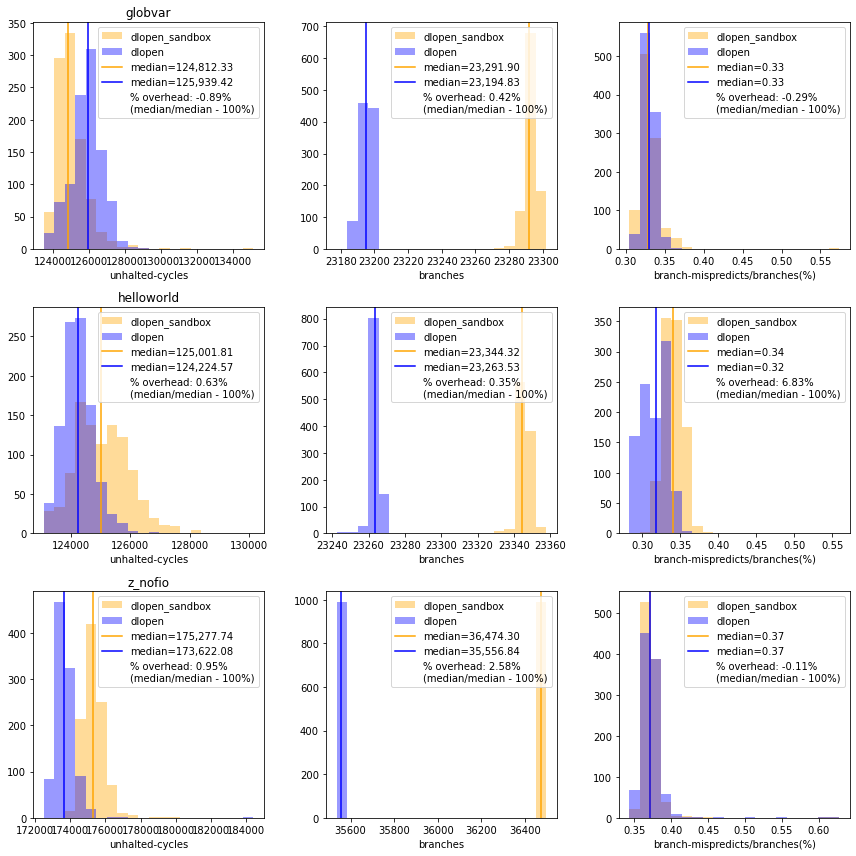

In [4]:
fig, axss = plt.subplots(nrows=len(libnames), ncols=len(counters), figsize=(12, 12))

for rowindex, libname in enumerate(sorted(libnames)):
    axs = axss[rowindex] 
    axs[0].set_title(libname)
    
    for counter, ax in zip(sorted(counters, reverse=True), axs.ravel()):
        ax.hist(
            [baseline.loc[libname, counter].values, sandbox.loc[libname, counter].values],
            bins=20, histtype='stepfilled',
            color=['blue', 'orange'], alpha=.4,
            label=['dlopen', 'dlopen_sandbox']
        )
        baseline_median = baseline.loc[libname, counter].median()
        sandbox_median = sandbox.loc[libname, counter].median()
        ax.axvline(x=sandbox_median, color='orange', label=f"median={sandbox_median:,.2f}")
        ax.axvline(x=baseline_median, color='blue', label=f"median={baseline_median:,.2f}")
        ax.set_xlabel(counter)
        handles, labels = ax.get_legend_handles_labels()
        handles.append(mpatches.Patch(color='white',
                                      label=f"% overhead: {100 * (sandbox_median / baseline_median - 1):.2f}%\n"
                                            "(median/median - 100%)"))
        ax.legend(handles=handles, loc='upper right')

fig.tight_layout()

plt.show()